In [1]:
## Visualisation for Univariate Encoder-Decoder Long Short-Term Memory model (EDLSTM)
## by Jimmy Cheung

In [2]:
## No need to carry out multiple (30) experiments and calculate RMSE, MAE, MAPE here
## No need to ask for model specification here, if wish to change parameters please do so manually

In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt   
import matplotlib.ticker as ticker
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
# wraps dataset into tensor -> appropriate for pytorch -> DataLoader
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, decoder_inputs, outputs):
        self.inputs = inputs
        self.decoder_inputs = decoder_inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        decoder_input = self.decoder_inputs[idx]
        y = self.outputs[idx]
        return (torch.tensor(x, dtype=torch.float32), 
        	torch.tensor(decoder_input, dtype=torch.float32), 
        	torch.tensor(y, dtype=torch.float32))

In [5]:
class Encoder(nn.Module):
    def __init__(self, num_features, hidden_sizes):
        super(Encoder, self).__init__()
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        
        self.lstms = nn.ModuleList()
        input_size = num_features
        for hs in hidden_sizes:
            self.lstms.append(nn.LSTM(input_size, hs, batch_first=True))
            input_size = hs

    def forward(self, x):
        hidden_states, cell_states = [], []
        for i, lstm in enumerate(self.lstms):
            h = torch.zeros(1, x.size(0), self.hidden_sizes[i], device=x.device)
            c = torch.zeros(1, x.size(0), self.hidden_sizes[i], device=x.device)
            x, (h, c) = lstm(x, (h, c))
            hidden_states.append(h)
            cell_states.append(c)
        return hidden_states, cell_states

In [6]:
class Decoder(nn.Module):
    def __init__(self, num_features, hidden_sizes):
        super(Decoder, self).__init__()
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        
        self.lstms = nn.ModuleList()
        input_size = num_features
        for hs in hidden_sizes:
            self.lstms.append(nn.LSTM(input_size, hs, batch_first=True))
            input_size = hs
        
        self.fc = nn.Linear(hidden_sizes[-1], 1)

    def forward(self, x, hidden_states, cell_states):
        for i, lstm in enumerate(self.lstms):
            h, c = hidden_states[i], cell_states[i]
            x, (h, c) = lstm(x, (h, c))
        out = self.fc(x)
        return out, hidden_states, cell_states

In [7]:
class EDLSTM(nn.Module):
    def __init__(self, num_features, hidden_sizes):
        super(EDLSTM, self).__init__()
        self.encoder = Encoder(num_features, hidden_sizes)
        self.decoder = Decoder(1, hidden_sizes)

    def forward(self, encoder_inputs, decoder_inputs):
        hidden_states, cell_states = self.encoder(encoder_inputs)
        decoder_inputs = decoder_inputs.unsqueeze(-1)
        outputs, hidden_states, cell_states = self.decoder(decoder_inputs, 
        	hidden_states, cell_states)
        return outputs

In [8]:
def split_series(series, input_size, output_size, train_ratio, seed):
    X, y, decoder_inputs = [], [], []
    total_size = input_size + output_size
    for i in range(len(series) - total_size + 1):
        X.append(series[i:i + input_size]) # encoder input
        # target output (the future sequence)
        y.append(series[i + input_size:i + total_size])
        # decoder input (previous target shifted by one step)
        decoder_inputs.append(
            series[i + input_size - 1:i + input_size + output_size - 1])
    # Split into train/test
    (X_train, X_test, y_train, y_test, decoder_train, 
    	decoder_test) = train_test_split(
        X, y, decoder_inputs, train_size=train_ratio, random_state=seed)
    return X_train, X_test, y_train, y_test, decoder_train, decoder_test

In [9]:
# Lorenz
def lorenz(xyz, *, s=10, r=28, b=2.667):
	x, y, z = xyz
	x_dot = s*(y - x)
	y_dot = r*x - y - x*z
	z_dot = x*y - b*z
	return np.array([x_dot, y_dot, z_dot])

In [10]:
# DATA HANDLING - CHANGE DATA AS DESIRED
# FOR LORENZ, CHANGE DIM = 0,1,2 FOR X,Y,Z VALUES

# data = 'bitcoin'
# data = 'ethereum'
# data = 'sunspots'
# data = 'mackey-glass'
data = 'lorenz'

if data == 'bitcoin' or data == 'ethereum':
    if data == 'bitcoin':
        df = pd.read_csv('../data/bitcoin.csv')
    else:
        df = pd.read_csv('../data/ethereum.csv')
    target = df.iloc[:,4].copy() # only interested in close price
elif data == 'sunspots':
    df = pd.read_csv('../data/sunspots.csv')
    target = df['Monthly Mean Total Sunspot Number']
elif data == 'mackey-glass' or data == 'lorenz':
    if data == 'mackey-glass':
        from reservoirpy.datasets import mackey_glass 
        df = mackey_glass(n_timesteps = 3000, tau=75, a=0.2, b=0.1, n=10, x0=1.2, h=1.0, seed=5925)
    else:
        dt = 0.01
        num_steps = 3000
        dim = 2 # x-dim: 0, y-dim: 1, z-dim: 2
        xyzs = np.empty((num_steps+1, 3))  
        xyzs[0] = (0., 1., 1.05)  
        for i in range(num_steps):
            xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
        df = xyzs[:, dim] 
    df = df.flatten()
    target = pd.Series(df, name = 'Value')
    target.index = range(len(target))

target_reshaped = np.array(target).reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1)) # normalise response variable
target_scaled = scaler.fit_transform(target_reshaped).flatten()

In [11]:
# PARAMETERS - we are setting fixed values here (same values as our paper)
input_size = 6
output_size = 5
train_ratio = 0.7
seed = 5925

# Hyperparameters
num_features = 1 # the main difference between U & M
hidden_neurons = [64, 32]
num_epochs = 100

In [12]:
X_train, X_test, y_train, y_test, decoder_train, decoder_test = split_series(target_scaled, input_size, output_size, train_ratio, seed)
# torch.tensor wrap X_train, X_test, y_train, y_test to feed DataLoader
df_train = Time_Series_Dataset(X_train, decoder_train, y_train)
df_test = Time_Series_Dataset(X_test, decoder_test, y_test)
# DataLoader -> model
# changing batch size affect model accuracy significantly (future work)
# shuffle = False to maintain sequence structure within input_window
df_train = DataLoader(df_train, batch_size = 16, shuffle = False)
df_test = DataLoader(df_test, batch_size = 16, shuffle = False)

In [13]:
model = EDLSTM(num_features, hidden_neurons)
criterion = nn.MSELoss() # loss & optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    for encoder_inputs, decoder_inputs, targets in df_train:
        batch_size = encoder_inputs.shape[0] # Determine batch size 
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(
            batch_size, input_size, num_features)
        # Output steps dimension only
        decoder_inputs = decoder_inputs.view(batch_size, output_size) 
        # Add feature dimension
        targets = targets.view(batch_size, output_size, 1)  
        outputs = model(encoder_inputs, decoder_inputs) # Forward pass
        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_size, 1)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
# MODEL TESTING
model.eval()
y_pred, y_test = [], []

with torch.no_grad():
    for encoder_inputs, decoder_inputs, targets in df_test:
        # Determine batch size dynamically
        batch_size = encoder_inputs.shape[0]
        # Correctly reshape the inputs
        encoder_inputs = encoder_inputs.view(
            batch_size, input_size, num_features)
        # Output steps dimension only
        decoder_inputs = decoder_inputs.view(batch_size, output_size)  
        # Add feature dimension
        targets = targets.view(batch_size, output_size, 1)  
        # Forward pass
        outputs = model(encoder_inputs, decoder_inputs)
        # Reshape outputs to match targets
        outputs = outputs.view(batch_size, output_size, 1)

        y_pred.append(outputs.detach().cpu().numpy())
        y_test.append(targets.detach().cpu().numpy())

y_pred = np.concatenate(y_pred, axis = 0).squeeze(-1) # convert list to numpy
y_test = np.concatenate(y_test, axis = 0).squeeze(-1)

# inverse transform (get back to original scale)
pred_vals = torch.tensor(scaler.inverse_transform(y_pred)) 
act_vals = torch.tensor(scaler.inverse_transform(y_test)) 

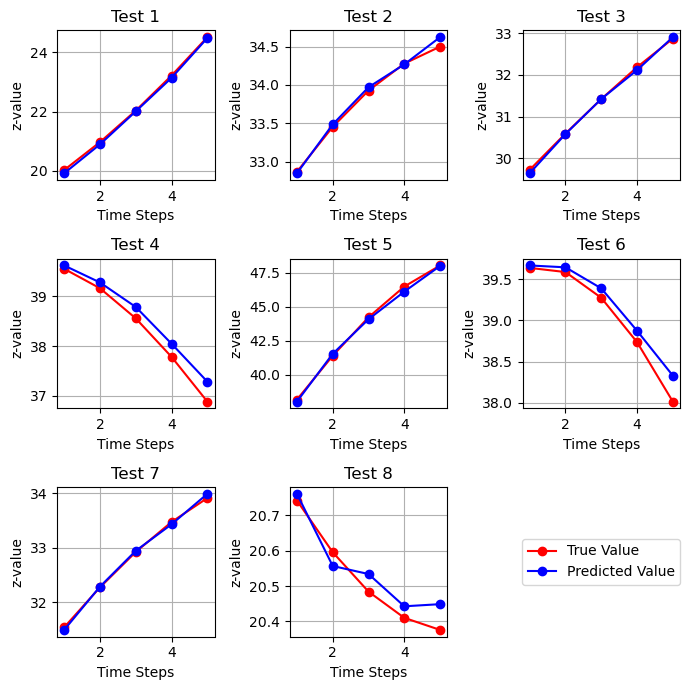

In [15]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(3, 3, figsize=(7, 7))  # Adjusted figure size for better spacing
axs = axs.flatten()
for i in range(8):  # Only plot the first 8 graphs
    ax = axs[i]
    ax.plot(time_steps, act_vals[i], marker='o', linestyle='-', color='red', label='True Value')
    ax.plot(time_steps, pred_vals[i], marker='o', linestyle='-', color='blue', label='Predicted Value')
    ax.set_title(f'Test {i+1}')
    if data == 'bitcoin' or data == 'ethereum':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Price (USD)')
    elif data == 'sunspots':
        ax.set_xlabel('Months')
        ax.set_ylabel('Number of Sunspots')
    elif data == 'mackey-glass':
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
    elif data == 'lorenz':
        ax.set_xlabel('Time Steps')
        if dim == 0:
            ax.set_ylabel('x-value')
        elif dim == 1:
            ax.set_ylabel('y-value')
        elif dim == 2:
            ax.set_ylabel('z-value')
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Ensure x-axis only displays integers

# Remove the 9th subplot
fig.delaxes(axs[8])
# Add legend in the 9th subplot's space
axs[8] = fig.add_subplot(3, 3, 9)
axs[8].axis('off')  # Hide the axes for the legend subplot
axs[8].legend(handles=[axs[0].lines[0], axs[0].lines[1]], loc='center')  # Center the legend

# Adjust layout
plt.tight_layout()

if data == 'bitcoin':
    plt.savefig('results/edlstm/univariate/BTC-U-EDLSTM.png')
elif data == 'ethereum':
    plt.savefig('results/edlstm/univariate/ETH-U-EDLSTM.png')
elif data == 'sunspots':
    plt.savefig('results/edlstm/univariate/Sunspots-EDLSTM.png')
elif data == 'mackey-glass':
    plt.savefig('results/edlstm/univariate/MG-EDLSTM.png')
elif data == 'lorenz':
    if dim == 0: # X-dim
        plt.savefig('results/edlstm/univariate/LorenzX-EDLSTM.png')
    elif dim == 1:
        plt.savefig('results/edlstm/univariate/LorenzY-EDLSTM.png')
    elif dim == 2:
        plt.savefig('results/edlstm/univariate/LorenzZ-EDLSTM.png')

plt.show()
plt.close()